# モジュールをインポート

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# 学習歴史を読み込み

In [17]:
results_path = "keras_2020_01_29_02_07"
results_path = "./results/" + results_path 
with open(results_path + "/train_hist", "rb") as file:
    history = pickle.load(file)

# 学習正解率を描画

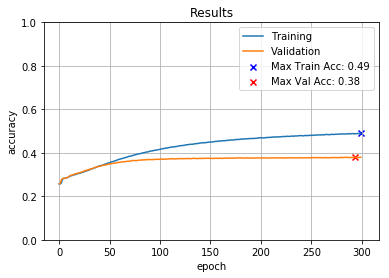

In [18]:
plt.plot(history['acc'], color="C0", label="Training")
plt.plot(history['val_acc'], color="C1", label="Validation")
max_val_index = np.argmax(history["acc"])
max_val = history["acc"][max_val_index]
# plt.annotate("Max Acc", xy=(max_val_index, history["val_acc"][max_val_index]), xycoords="data", label=("Max Val Acc: " + str(max_val.round(2))))
plt.scatter(max_val_index, history["acc"][max_val_index], marker="x", color="blue", label=("Max Train Acc: " + str(max_val.round(3))))
max_val_index = np.argmax(history["val_acc"])
max_val = history["val_acc"][max_val_index]
# plt.annotate("Max Acc", xy=(max_val_index, history["val_acc"][max_val_index]), xycoords="data", label=("Max Val Acc: " + str(max_val.round(2))))
plt.scatter(max_val_index, history["val_acc"][max_val_index], marker="x", color="red", label=("Max Val Acc: " + str(max_val.round(3))))
plt.title("Results")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.show()

# 学習損失を描画

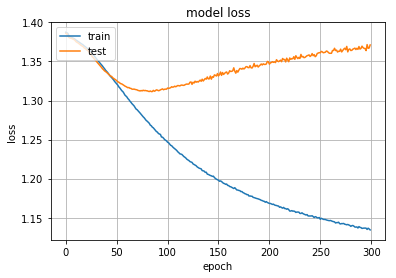

In [19]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# 検証データセットを読み込み

In [27]:
random_state = 33
dataset_dir = "./dataset/preprocessed_dataset/"
result_dir = "./results/"
with open(dataset_dir+"1_109_1x4_dataset_3D_win_10_normalize_False_overlap_True_no_eye_close.pkl", "rb") as fp:
    dataset = pickle.load(fp)
with open(dataset_dir+"1_109_1x4_label_3D_win_10_normalize_False_overlap_True_no_eye_close.pkl", "rb") as fp:
    labels = pickle.load(fp)
height = dataset.shape[2]
width = dataset.shape[3]
window_size = dataset.shape[1]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(dataset, labels, test_size=0.25, random_state=random_state, shuffle=True)
print("Train dataset shape:", X_train.shape)
print("Train label shape:", y_train.shape)
print("Test dataset shape:", X_valid.shape)
print("Test label shape:", y_valid.shape)

Train dataset shape: (620241, 10, 1, 4)
Train label shape: (620241,)
Test dataset shape: (206747, 10, 1, 4)
Test label shape: (206747,)


# ラベルエンコーディング

In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

y_train = y_train.reshape(-1, 1)
y_train = ohe.fit_transform(y_train)
y_valid = y_valid.reshape(-1, 1)
y_valid = ohe.transform(y_valid)

# 正規化

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = X_train.reshape(-1, height*width)
X_valid = X_valid.reshape(-1, height*width)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_train = X_train.reshape(-1, window_size, height, width, 1)
X_valid = X_valid.reshape(-1, window_size, height, width, 1)

# モデルを定義

In [30]:
from tensorflow.keras.models import load_model

model = load_model(results_path + "/model/model.h5")

# モデルの確認

In [31]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1, 4, 1)]     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 10, 1, 4, 128)     384       
_________________________________________________________________
reshape (Reshape)            (None, 10, 512)           0         
_________________________________________________________________
dense (Dense)                (None, 10, 256)           131328    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 512)           787968

# テストデータを分類

In [32]:
n_labels = y_valid.shape[1]
batch_size = 300
y_pred = model.predict(X_valid, batch_size=batch_size, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

206747/206747 [==============================] - 16s 75us/sample


# 精度と正解率の曲線

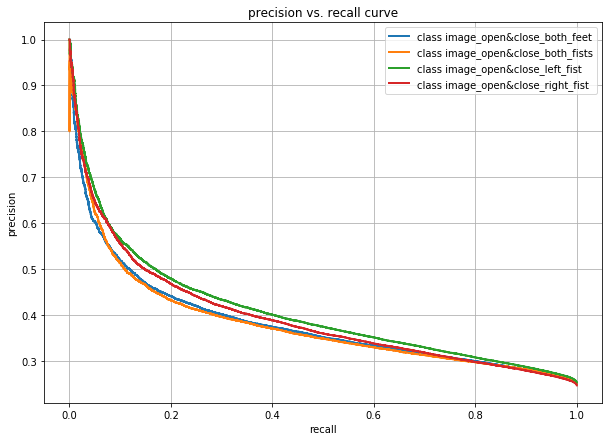

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from scipy import interp
from itertools import cycle
lw = 2
precision = dict()
recall = dict()
plt.figure(figsize=(10, 7))
for i in range(n_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_valid[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=lw, label="class {}".format(ohe.categories_[0][i]))
plt.xlabel("recall")
plt.ylabel("precision")
plt.grid()
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.savefig(results_path + "/precision_recall_curve", bbox_inches="tight")
#     plt.clf()
plt.show()

# 混同行列

In [34]:
from sklearn.metrics import classification_report

y_valid_inv = ohe.inverse_transform(y_valid)
y_pred_inv = ohe.inverse_transform(y_pred)
print(classification_report(y_valid_inv, y_pred_inv, target_names=ohe.categories_[0]))
with open(results_path + "/classification_report.txt", "w") as file:
    file.write(classification_report(y_valid_inv, y_pred_inv, target_names=ohe.categories_[0]))

                             precision    recall  f1-score   support

 image_open&close_both_feet       0.38      0.36      0.36     51689
image_open&close_both_fists       0.37      0.36      0.36     51946
 image_open&close_left_fist       0.38      0.43      0.41     52173
image_open&close_right_fist       0.39      0.38      0.38     50939

                   accuracy                           0.38    206747
                  macro avg       0.38      0.38      0.38    206747
               weighted avg       0.38      0.38      0.38    206747



# ROC曲線

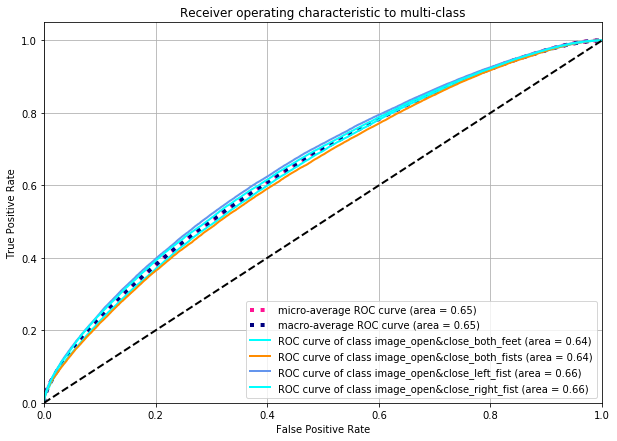

In [35]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_labels):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_labels)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
        label='micro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["micro"]),
        color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
        label='macro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["macro"]),
        color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(ohe.categories_[0][i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.grid()
plt.savefig(results_path + "/roc_curve", bbox_inches="tight")
# plt.clf()
plt.show()

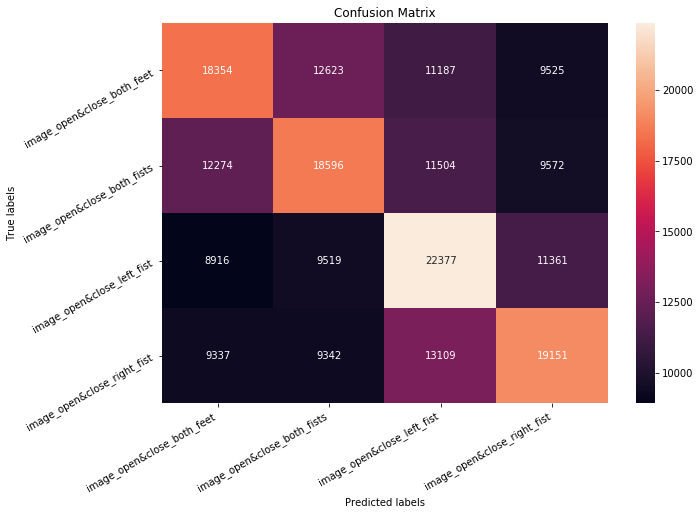

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_valid_inv, y_pred_inv)
cm_normalized = confusion_matrix(y_valid_inv, y_pred_inv, normalize="true")
with open(results_path + "/confusion_matrix.txt", "w") as file:
    file.write(np.array_str(cm))
with open(results_path + "/confusion_matrix_normalized.txt", "w") as file:
    file.write(np.array_str(cm_normalized))
import seaborn as sns
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(ohe.categories_[0])
ax.yaxis.set_ticklabels(ohe.categories_[0])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.savefig(results_path + "/confusion_matrix", bbox_inches="tight")
# plt.clf()
plt.show()

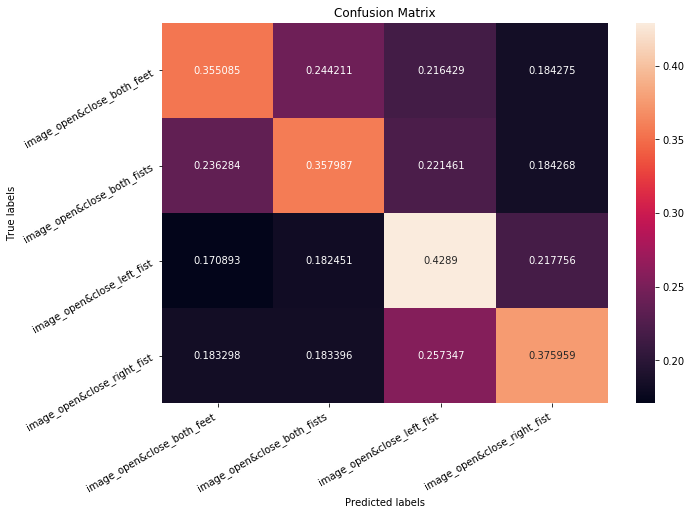

In [37]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.heatmap(cm_normalized, annot=True, fmt="g", ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(ohe.categories_[0])
ax.yaxis.set_ticklabels(ohe.categories_[0])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.savefig(results_path + "/confusion_matrix_normalized", bbox_inches="tight")
plt.show()